In [1]:
%matplotlib inline

import edward as ed
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import six
import tensorflow as tf
import time
from edward.models import (
    Categorical, Dirichlet, Empirical, InverseGamma, InverseGammaWithSoftplusConcentrationRate,
    MultivariateNormalDiag, Normal, ParamMixture, Mixture)

plt.style.use('ggplot')

# Data

In [2]:
def build_toy_dataset(N, K):
    pi = np.array([1/3, 1/3, 1/3])
    mus = [[1, 1], [-1, -1], [-2,2]]
    stds = [[0.1, 0.1], [0.1, 0.1], [0.2, 0.2]]
    x = np.zeros((N, 2), dtype=np.float32)
    for n in range(N):
        k = np.argmax(np.random.multinomial(1, pi))
        x[n, :] = np.random.multivariate_normal(mus[k], np.diag(stds[k]))

    return x


N = 500  # number of data points
K = 3  # number of components
D = 2  # dimensionality of data

x_train = build_toy_dataset(N, K)

x_train.shape

(500, 2)

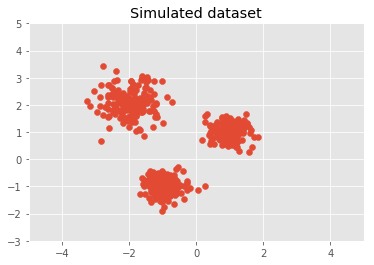

In [3]:
plt.scatter(x_train[:, 0], x_train[:, 1])
plt.axis([-5, 5, -3, 5])
plt.title("Simulated dataset")
plt.show()

# Model

$$\text{Pr}(\textbf{x}_i|\boldsymbol{\pi},\boldsymbol{\mu},\boldsymbol{\Sigma})=\sum_{k=1}^K \pi_k \text{N}(\textbf{x}_i|\mu_k,\Sigma_k)$$

$$\begin{aligned}
\pi_k\sim&\text{Dir}(\pi_k|\boldsymbol{\alpha})\\
\mu_k\sim&\text{N}(\mu_k|\mathbf{0},\mathbf{I})\\
\sigma_k^2 \sim&\text{InverseGamma}(a,b)
\end{aligned}$$

In [22]:
"""
pi = Dirichlet(tf.ones(K))
mu = Normal(tf.zeros(D), tf.ones(D), sample_shape=K)
sigmasq = InverseGamma(tf.ones(D), tf.ones(D), sample_shape=K)
x = ParamMixture(pi, {'loc': mu, 'scale_diag': tf.sqrt(sigmasq)},
                 MultivariateNormalDiag,
                 sample_shape=N)
z = x.cat

"""
pi = Dirichlet(tf.ones(K))
mu = Normal(tf.zeros(D), tf.ones(D), sample_shape=K) # shape K by D
sigmasq = InverseGamma(tf.ones(D), tf.ones(D), sample_shape=K) # shape K by D
cat = Categorical(probs=pi, sample_shape=N)
#components = [
#    MultivariateNormalDiag(mu[k], tf.sqrt(sigmasq[k]), sample_shape=N)
#    for k in range(K)]
components = [
    MultivariateNormalDiag(tf.gather(mu,k), 
                               tf.sqrt(tf.gather(sigmasq, k)),sample_shape=N)
    for k in range(K)]
x = Mixture(cat=cat, components=components, sample_shape=N)


TensorShape([Dimension(3), Dimension(2)])

# Inference (only for mu)

In [ ]:
qmu = Normal(
    loc=tf.Variable(tf.random_normal([K, D])),
    scale=tf.nn.softplus(tf.Variable(tf.ones([K, D]))))

qsigma_sq = InverseGamma(tf.nn.softplus(tf.Variable(tf.random_normal([K, D]))), 
                         tf.nn.softplus(tf.Variable(tf.random_normal([K, D])*0.5)))

/Users/leah/Columbia/courses/ml_prob_programming/ENV/lib/python3.6/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \


  50/2000 [  2%]                                ETA: 3295s | Loss: 1866.071  
Inferred cluster means:
[[-1.6693013   1.8315246 ]
 [-0.674442   -0.03988221]
 [ 0.34561136  0.63831705]]
 100/2000 [  5%] █                              ETA: 1639s | Loss: 1843.311
Inferred cluster means:
[[-1.6180805  1.7634394]
 [-0.9038325 -0.6466626]
 [ 0.6194528  0.9881835]]
 150/2000 [  7%] ██                             ETA: 1088s | Loss: 1887.912
Inferred cluster means:
[[-1.7397997   1.8122859 ]
 [-0.8236396  -0.5572061 ]
 [ 0.6908876   0.91761535]]
 200/2000 [ 10%] ███                            ETA: 806s | Loss: 1863.772 
Inferred cluster means:
[[-1.7347629   1.7722563 ]
 [-0.8440941  -0.59667814]
 [ 0.65352523  0.9330764 ]]
 250/2000 [ 12%] ███                            ETA: 636s | Loss: 1903.082
Inferred cluster means:
[[-1.6728203  1.7342739]
 [-0.9012916 -0.5914128]
 [ 0.7702934  0.9840813]]
 300/2000 [ 15%] ████                           ETA: 522s | Loss: 1862.319
Inferred cluster means:
[[

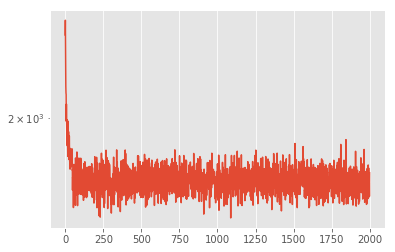

In [20]:
def do_inference(inference_algo):
    inference = inference_algo(*({mu: qmu}, {x: x_train}))
    
    inference.initialize(n_iter=2000, n_print=50, n_samples=50)
    
    sess = ed.get_session()
    init = tf.global_variables_initializer()
    init.run()
    
    learning_curve = []

    for _ in range(inference.n_iter):
        info_dict = inference.update()
        inference.print_progress(info_dict)
        t = info_dict['t']
        if t % inference.n_print == 0:
            print("\nInferred cluster means:")
            print(sess.run(qmu.loc))
        learning_curve.append(info_dict['loss'])
    
    plt.semilogy(learning_curve)

do_inference(ed.KLqp)
    

In [ ]:
inference = ed.KLqp({mu: qmu}, data={x: x_train}) # pi:qpi
inference.initialize(n_iter=2000, n_print=50, n_samples=50)
sess = ed.get_session()
init = tf.global_variables_initializer()
init.run()

In [ ]:
learning_curve = []

for _ in range(inference.n_iter):
    info_dict = inference.update()
    inference.print_progress(info_dict)
    t = info_dict['t']
    if t % inference.n_print == 0:
        print("\nInferred cluster means:")
        print(sess.run(qmu.loc))
    learning_curve.append(info_dict['loss'])
    
plt.semilogy(learning_curve)

# Use RB-BBVI

In [ ]:
inference2 = ed.ScoreRBKLqp({mu: qmu}, data={x: x_train}) # pi:qpi
inference2.initialize(n_iter=2000, n_print=50, n_samples=50)
sess = ed.get_session()
init = tf.global_variables_initializer()
init.run()

In [ ]:
learning_curve2 = []

for _ in range(inference2.n_iter):
    info_dict = inference2.update()
    inference2.print_progress(info_dict)
    t = info_dict['t']
    if t % inference2.n_print == 0:
        print("\nInferred cluster means:")
        print(sess.run(qmu.loc))
    learning_curve2.append(info_dict['loss'])
    
plt.semilogy(learning_curve2)

# Use reparametrization-BBVI (only for mu)

In [ ]:
#ReparameterizationKLqp
inference3 = ed.ReparameterizationKLqp({mu: qmu}, data={x: x_train}) # pi:qpi
inference3.initialize(n_iter=2000, n_print=50, n_samples=50)
sess = ed.get_session()
init = tf.global_variables_initializer()
init.run()

In [ ]:
learning_curve3 = []

for _ in range(inference3.n_iter):
    info_dict = inference3.update()
    inference3.print_progress(info_dict)
    t = info_dict['t']
    if t % inference3.n_print == 0:
        print("\nInferred cluster means:")
        print(sess.run(qmu.loc))
    learning_curve3.append(info_dict['loss'])
    
plt.semilogy(learning_curve3)

# Use reparametrization-BBVI for mu and sigma

In [ ]:
#ReparameterizationKLqp
inference4 = ed.ReparameterizationKLqp({mu: qmu, sigmasq: qsigma_sq}, data={x: x_train}) # pi:qpi
inference4.initialize(n_iter=2000, n_print=50, n_samples=50)
sess = ed.get_session()
init = tf.global_variables_initializer()
init.run()

In [ ]:
learning_curve4 = []

for _ in range(inference4.n_iter):
    info_dict = inference4.update()
    inference4.print_progress(info_dict)
    t = info_dict['t']
    if t % inference3.n_print == 0:
        print("\nInferred cluster means:")
        print(sess.run(qmu.loc))
    learning_curve4.append(info_dict['loss'])
    
plt.semilogy(learning_curve4)

# Criticism

In [ ]:
# Calculate likelihood for each data point and cluster assignment,
# averaged over many posterior samples. ``x_post`` has shape (N, 100, K, D).
mu_sample = qmu.sample(100)
sigmasq_sample = qsigmasq.sample(100)
x_post = Normal(loc=tf.ones([N, 1, 1, 1]) * mu_sample,
                scale=tf.ones([N, 1, 1, 1]) * tf.sqrt(sigmasq_sample))
x_broadcasted = tf.tile(tf.reshape(x_train, [N, 1, 1, D]), [1, 100, K, 1])

# Sum over latent dimension, then average over posterior samples.
# ``log_liks`` ends up with shape (N, K).
log_liks = x_post.log_prob(x_broadcasted)
log_liks = tf.reduce_sum(log_liks, 3)
log_liks = tf.reduce_mean(log_liks, 1)

In [ ]:
# Choose the cluster with the highest likelihood for each data point.
clusters = tf.argmax(log_liks, 1).eval()

In [ ]:
plt.scatter(x_train[:, 0], x_train[:, 1], c=clusters, cmap=cm.bwr)
plt.axis([-5, 5, -3, 5])
plt.title("Predicted cluster assignments")
plt.show()

# Let's infernece all latent variables

In [7]:
#qpi_alpha = tf.nn.softplus(tf.Variable(tf.ones(K)))
qpi = Dirichlet([1/3, 1/3, 1/3])

qmu = Normal(
    loc=tf.Variable(tf.random_normal([K, D])),
    scale=tf.nn.softplus(tf.Variable(tf.ones([K, D]))))

qsigmasq = InverseGammaWithSoftplusConcentrationRate(tf.Variable(tf.random_normal([K, D])),
                                                     tf.Variable(tf.random_normal([K, D])))

# should not inference z since it is summed out in the Mixture model.
# could inference z in ParamsMixture

In [ ]:
inference5 = ed.KLqp({mu: qmu, sigmasq: qsigmasq}, data={x: x_train}) # pi:qpi
inference5.initialize(n_iter=2000, n_print=50, n_samples=10)
sess = ed.get_session()
init = tf.global_variables_initializer()
init.run()

In [ ]:
learning_curve5 = []

for _ in range(inference5.n_iter):
    info_dict = inference5.update()
    inference5.print_progress(info_dict)
    t = info_dict['t']
    if t % inference5.n_print == 0:
        print("\nInferred cluster means:")
        print(sess.run(qmu.loc))
    learning_curve5.append(info_dict['loss'])
    
plt.semilogy(learning_curve5)

In [8]:
inference6 = ed.KLqp({pi: qpi, mu: qmu}, data={x: x_train}) # pi:qpi
inference6.initialize(n_iter=2000, n_print=50, n_samples=100)
sess = ed.get_session()
init = tf.global_variables_initializer()
init.run()

/Users/leah/Columbia/courses/ml_prob_programming/ENV/lib/python3.6/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \


  50/2000 [  2%]                                ETA: 4335s | Loss: 3073.022  
Inferred cluster means:
[[ 1.231583    1.9405639 ]
 [-1.1726229  -0.03713531]
 [ 2.958682    0.02610952]]
 100/2000 [  5%] █                              ETA: 2226s | Loss: 7125.596
Inferred cluster means:
[[ 0.8931207   2.2539053 ]
 [-0.75723016 -0.0476637 ]
 [ 2.4349089   0.8882948 ]]
 150/2000 [  7%] ██                             ETA: 1446s | Loss: 2621.638
Inferred cluster means:
[[ 0.22161335  2.0251443 ]
 [-1.8577642  -0.1092444 ]
 [ 2.6593647   1.5183487 ]]
 200/2000 [ 10%] ███                            ETA: 1056s | Loss: 3518.862
Inferred cluster means:
[[ 1.0707287  2.4522274]
 [-2.1655948  0.3254221]
 [ 2.3226242  1.2273598]]
 250/2000 [ 12%] ███                            ETA: 822s | Loss: 2890.240 
Inferred cluster means:
[[ 0.8025345   2.2618382 ]
 [-0.94254744 -0.11583593]
 [ 2.255344    1.4947284 ]]
 300/2000 [ 15%] ████                           ETA: 666s | Loss: 2329.308
Inferred cluster me

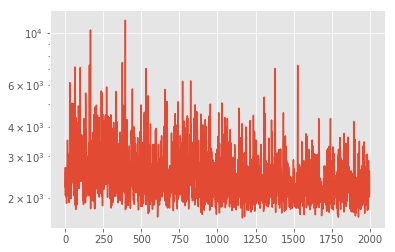

In [9]:
learning_curve6 = []

for _ in range(inference6.n_iter):
    info_dict = inference6.update()
    inference6.print_progress(info_dict)
    t = info_dict['t']
    if t % inference6.n_print == 0:
        print("\nInferred cluster means:")
        print(sess.run(qmu.loc))
    learning_curve6.append(info_dict['loss'])
    
plt.semilogy(learning_curve6)

In [15]:
qpi.concentration.eval()

array([0.33333334, 0.33333334, 0.33333334], dtype=float32)

In [ ]:
inference7 = ed.ReparameterizationKLqp({mu: qmu, sigmasq: qsigmasq}, data={x: x_train}) # pi:qpi
inference7.initialize(n_iter=2000, n_print=50, n_samples=10)
sess = ed.get_session()
init = tf.global_variables_initializer()
init.run()

# Inference

In [ ]:
# Calculate likelihood for each data point and cluster assignment,
# averaged over many posterior samples. ``x_post`` has shape (N, 100, K, D).
mu_sample = qmu.sample(100)
sigmasq_sample = qsigmasq.sample(100)
x_post = Normal(loc=tf.ones([N, 1, 1, 1]) * mu_sample,
                scale=tf.ones([N, 1, 1, 1]) * tf.sqrt(sigmasq_sample))
x_broadcasted = tf.tile(tf.reshape(x_train, [N, 1, 1, D]), [1, 100, K, 1])

# Sum over latent dimension, then average over posterior samples.
# ``log_liks`` ends up with shape (N, K).
log_liks = x_post.log_prob(x_broadcasted)
log_liks = tf.reduce_sum(log_liks, 3)
log_liks = tf.reduce_mean(log_liks, 1)

In [17]:
def xx(a,b):
     print("param 1 {} param 2 {}".format(a,b))

t = ("hello","manuel")
def yy(z):
     z(*("hello","manuel"))
        
yy(xx)

param 1 hello param 2 manuel
